In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
from collections import Counter
import math
import random
import statistics

import matplotlib.pyplot as plt
from unidecode import unidecode
import numpy as np
from scipy.stats import norm
from tqdm import tqdm
import torch
from transformers import AutoModelForMaskedLM, AutoTokenizer

from masked_models.utils import calculate_logprob, tokenize, model_init

import matplotlib.pyplot as plt
from functools import lru_cache
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [287]:
stereo_names = """
Emotional
Gentle
Empathetic
Neat
Social
Weak
Beautiful
Tough
Self-confident
Professional
Rational
Providers
Leaders
Childish
Sexual
Strong
""".strip().split('\n')
stereo_names = [
    f'{name} #{i+1}'
    for i, name in enumerate(stereo_names)
]

In [98]:

def bootstrap_ci(scores, alpha=0.95):
    """
    Bootstrapping based estimate.
    
    Return mean and confidence interval (lower and upper bound)
    """
    loc, scale = norm.fit(scores)    
    bootstrap = [sum(random.choices(scores, k=len(scores))) / len(scores) for _ in range(1000)]
    lower, upper = norm.interval(alpha, *norm.fit(bootstrap))
        
    return loc, lower, upper

def set_size(w,h, ax=None):
    """
    Used to size the figures with subplots
    
    https://stackoverflow.com/questions/44970010/axes-class-set-explicitly-size-width-height-of-axes-in-given-units
    """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

In [45]:
models = [
    'bert-base-multilingual-cased',
    'xlm-roberta-base',
    'xlm-roberta-large',
    'facebook/xlm-v-base',
    'facebook/xlm-roberta-xl',
]

# Visualizations

In [247]:
import glob
import pandas as pd

from transformers import AutoModelForMaskedLM, AutoTokenizer

@lru_cache
def file_results(filename):
    return list(map(float, open(filename, 'r').read().split('\n')))

@lru_cache
def model_results(model):

    df = pd.read_csv('./data/gender_variants.csv')

    tokenizer = AutoTokenizer.from_pretrained(model)
    def tokenizer_check(row):
        mw = tokenizer.tokenize(row.male)
        fw = tokenizer.tokenize(row.female)
        return len(mw) == len(fw) and sum(mwx != fwx for mwx, fwx in zip(mw, fw)) == 1

    def first_letter_check(row):
        mws, fws = row.male.split(), row.female.split()
        for mw, fw in zip(mws, fws):
            if mw != fw:
                return mw[0] == fw[0]

    df['score'] = file_results(f'./cache/predictions/mmlm/{model.split("/")[-1]}.txt')
    return df[(
        df.apply(first_letter_check, axis=1) &
        df.apply(tokenizer_check, axis=1) &
        ~df.duplicated(['male', 'female'])
    )]

@lru_cache
def model_stereotype_results(model, stereotype, language):
    df = model_results(model)
    scores = df[(df.stereotype == stereotype) & (df.language == language)].score
    return bootstrap_ci(list(scores))

def all_stereotype_score(model, language):
    return [
        model_stereotype_results(model, stereotype, language)[0]
        for stereotype in range(1, 17)
    ]

def all_stereotype_rank(model, language):
    return np.argsort(np.argsort(all_stereotype_score(model, language)))

def r_m(model, language):
    return np.mean([model_stereotype_results(model, stereotype, language) for stereotype in range(8, 17)])

def r_f(model, language):
    return np.mean([model_stereotype_results(model, stereotype, language) for stereotype in range(1, 7)])

0.31097762589560807 0.10732278407892633 0.12404165742619079


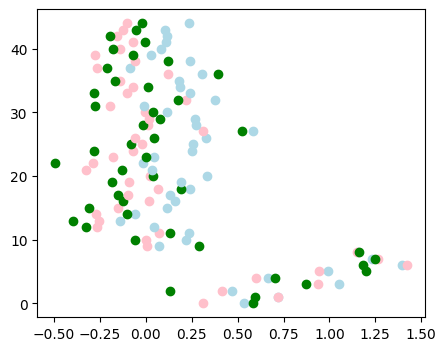

In [319]:
from itertools import product

def family_rate(model, language):
    family_words = 'family child children partner kids kid family\'s'.split()
    df = model_results(model)
    df = df[df.language == language]
    df = df[df.stereotype > 7]
    df = df[df.original.apply(lambda s: any(word in s for word in family_words))]
    return np.mean(df.score)

al, bl, cl = [], [], []
for i, (model, language) in enumerate(product(models, ['be', 'ru', 'uk', 'hr', 'sl', 'sr', 'cs', 'pl', 'sk'])):
    a, b, c = r_m(model, language), r_f(model, language), family_rate(model, language)
    plt.scatter([a], [i], c='lightblue')
    plt.scatter([b], [i], c='pink')
    plt.scatter([c], [i], c='green')
    al.append(a); bl.append(b); cl.append(c)
print(np.mean(al), np.mean(bl), np.mean(cl))


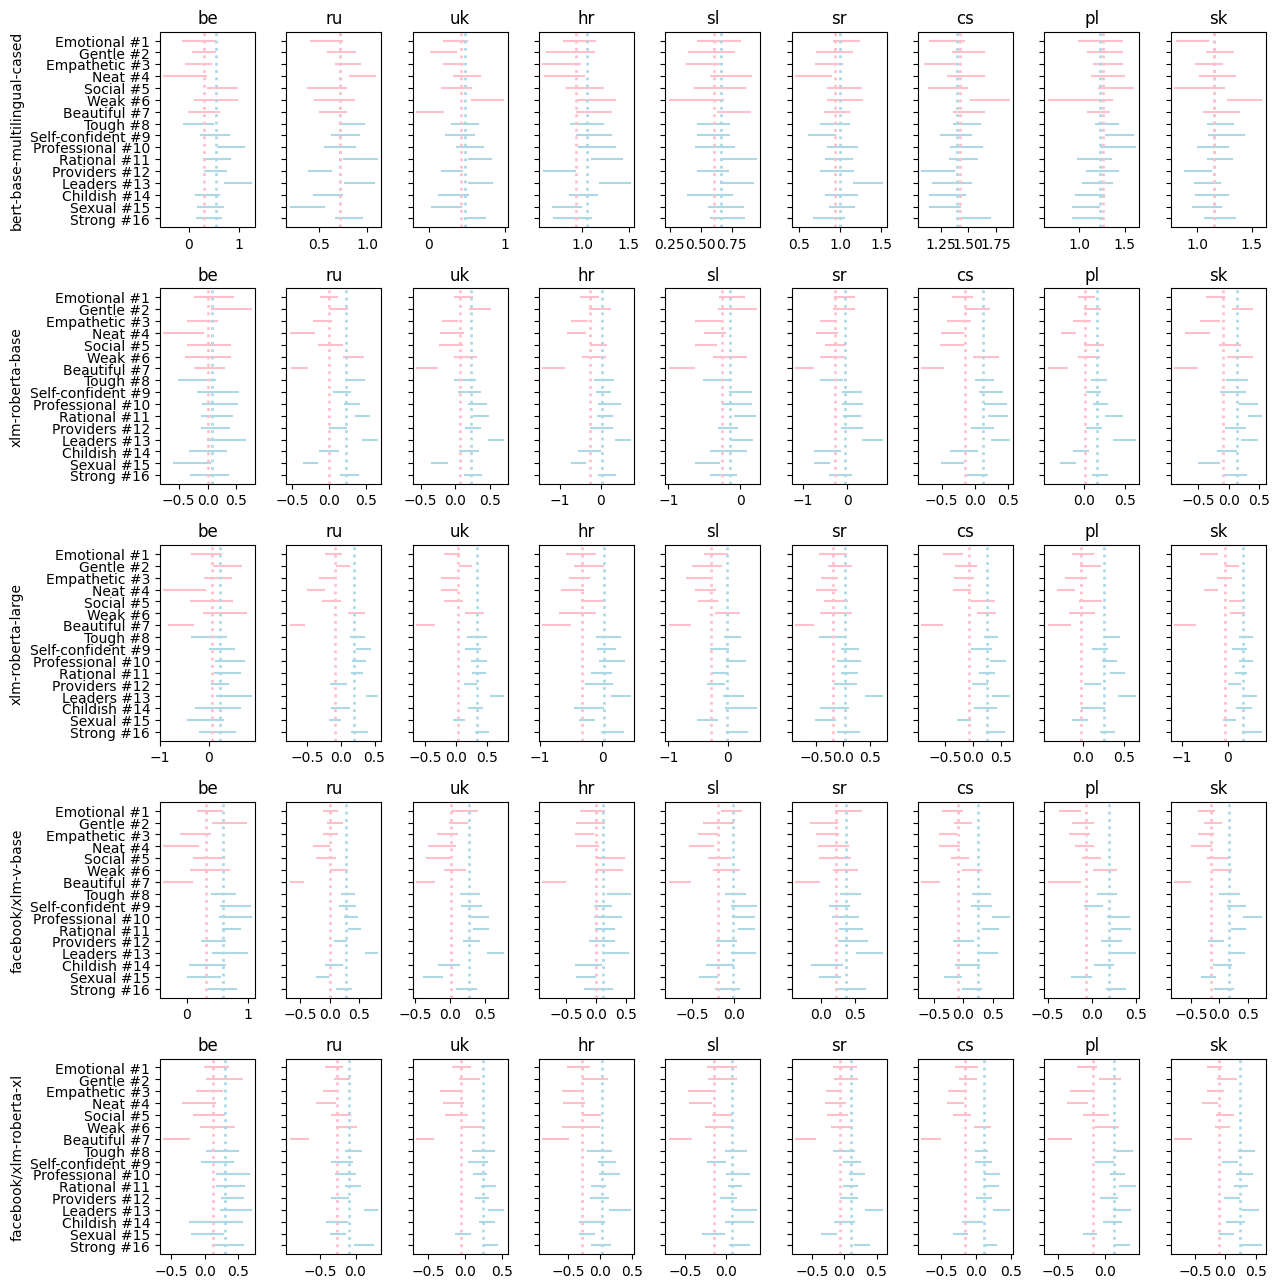

In [288]:
fig, axes = plt.subplots(5, 9, sharey=True)
# axes = axes.reshape(-1)
axes[0][0].invert_yaxis()

for i, model in enumerate(models):
    for ax, lang in zip(axes[i], ['be', 'ru', 'uk', 'hr', 'sl', 'sr', 'cs', 'pl', 'sk']):
        if ax == axes[i][0]:
            ax.set_ylabel(model)
        ax.set_title(lang)
        for stereotype in range(1, 17):
            middle, lower, upper = model_stereotype_results(model, stereotype, lang)
            ax.plot([lower, upper], [stereotype, stereotype], c=('pink' if stereotype < 8 else 'lightblue'))
        # ax.set_xlim(0, 1)
        ax.set_yticks(range(1, 17), stereo_names)
        ax.axvline(r_m(model, lang), linestyle=':', linewidth=2, color='lightblue')
        ax.axvline(r_f(model, lang), linestyle=':', linewidth=2, color='pink')

set_size(10, 10)
# plt.show()
plt.tight_layout()
plt.savefig('./figures/ml_all.pdf')

In [272]:
def format_ci(mean, lower, upper):
    return f'{lower:.2f} {mean:.2f} {upper:.2f}'

for model in models:
    print('\\midrule')
    print("& \multicolumn{16}{l}{\\texttt{", end='')
    print(short_model_name(model), end='')
    print("}} \\\\")
    for lang in ['be', 'ru', 'uk', 'hr', 'sl', 'sr', 'cs', 'pl', 'sk']:
        print(lang, *[
            format_ci(*model_stereotype_results(model, stereotype, lang))
            for stereotype in range(1, 17)
        ], sep=' & ', end=' \\\\\n')

\midrule
& \multicolumn{16}{l}{\texttt{bert-base-multi}} \\
be & -0.12 0.21 0.54 & 0.09 0.30 0.51 & -0.05 0.21 0.46 & -0.49 -0.06 0.36 & 0.38 0.67 0.97 & 0.14 0.55 0.96 & 0.00 0.30 0.61 & -0.08 0.19 0.47 & 0.25 0.53 0.82 & 0.57 0.84 1.10 & 0.30 0.56 0.81 & 0.34 0.53 0.73 & 0.72 0.98 1.23 & 0.16 0.38 0.61 & 0.18 0.43 0.69 & 0.16 0.40 0.63 \\
ru & 0.41 0.57 0.73 & 0.60 0.74 0.88 & 0.67 0.80 0.93 & 0.82 0.95 1.08 & 0.38 0.59 0.79 & 0.45 0.65 0.85 & 0.51 0.64 0.78 & 0.73 0.84 0.96 & 0.63 0.78 0.92 & 0.57 0.72 0.87 & 0.76 0.93 1.10 & 0.40 0.51 0.63 & 0.78 0.92 1.07 & 0.45 0.59 0.74 & 0.20 0.38 0.55 & 0.68 0.82 0.95 \\
uk & 0.20 0.35 0.49 & 0.04 0.20 0.35 & 0.20 0.33 0.45 & 0.32 0.49 0.67 & 0.18 0.36 0.55 & 0.57 0.77 0.96 & -0.15 0.01 0.18 & 0.31 0.47 0.65 & 0.22 0.41 0.61 & 0.36 0.54 0.72 & 0.53 0.67 0.80 & 0.17 0.30 0.44 & 0.53 0.67 0.82 & 0.13 0.32 0.52 & 0.05 0.23 0.42 & 0.47 0.61 0.75 \\
hr & 0.79 0.97 1.15 & 0.62 0.88 1.13 & 0.58 0.77 0.97 & 0.58 0.80 1.03 & 0.83 1.03 1.22 & 0.95 1.15 

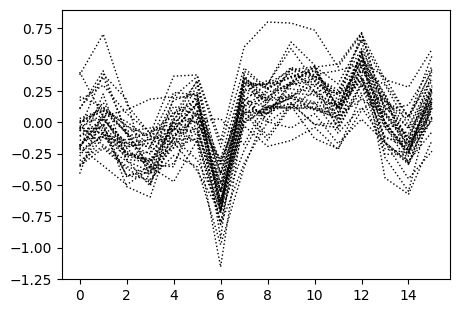

In [249]:
for model in models[1:]:
    for lang in ['cs', 'pl', 'sk', 'be', 'ru', 'uk', 'sr', 'hr', 'sl']:
        plt.plot(
            all_stereotype_score(model, lang),
            c='black',
            linestyle=':',
            linewidth=1,
        )

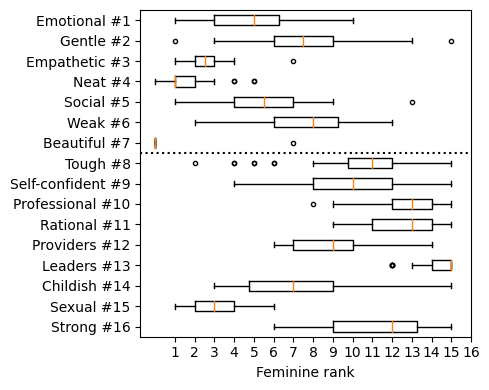

In [289]:
"""
Boxplot of positions (the rank in the list of 16 stereotypes) for all stereotypes.

The split between male and female stereotypes is more obvious now, as we "normalized" the results across different setups.
"""
plt.rcParams["figure.figsize"] = (5,4)

ranks = np.vstack([
    all_stereotype_rank(model, language)
    for model in models[1:]
    for language in ['cs', 'pl', 'sk', 'be', 'ru', 'uk', 'sr', 'hr', 'sl']
])
plt.boxplot(ranks, vert=False, sym='.');
plt.axhline(7.5, c='black', linestyle=':')
plt.gca().invert_yaxis()
plt.xticks(range(1,17))
plt.yticks(range(1,17), stereo_names)
plt.xlabel('Feminine rank')
plt.tight_layout()
plt.savefig('./figures/ml_ranks.pdf')

/tmp/ipykernel_63/471386746.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  d = np.vstack(


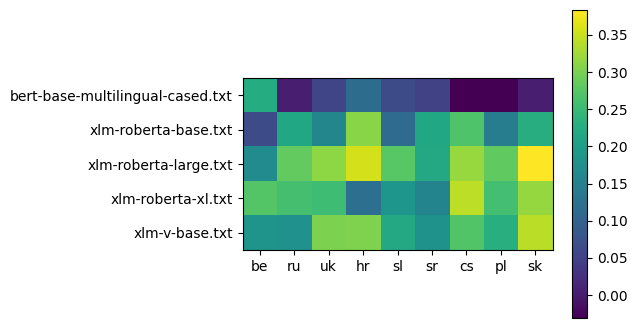

In [251]:
plt.xticks(range(9), langs)
plt.yticks(range(5), [f.split('/')[-1] for f in filenames])
d = np.vstack(
    [
        r_m(model, lang) - r_f(model, lang)
        for lang in langs
    ]
    for model in models
)
plt.colorbar(plt.imshow(d))

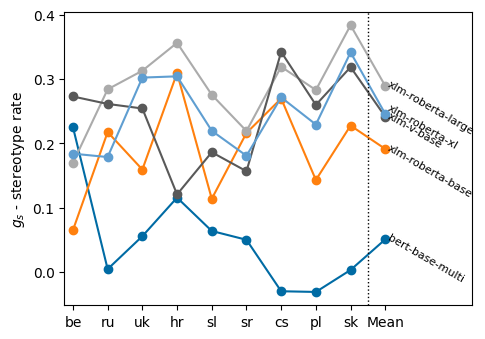

In [259]:
plt.rcParams["figure.figsize"] = (5,3.5)

def short_model_name(model):
    for s in ('uncased', 'v2', 'cased', 'generator'):
        if model.endswith('-' + s):
            model = model[:-len(s)-1]
    model = model.split('/')[-1]
    if model.endswith('lingual'):
        model = model[:-7]
    return model

plt.style.use('tableau-colorblind10')
means = np.mean(d, axis=1)
plt.plot(np.vstack([d.T, means]), marker='o')
for i, model in enumerate(models):
    model_name = short_model_name(model)
    ver_offset = {'xlm-roberta-xl': +0.007}.get(model_name, 0)
    plt.text(9.05, means[i] + ver_offset, model_name, fontsize=8, rotation=-30, rotation_mode='anchor')
plt.xticks(range(10), langs + ['Mean'])
plt.axvline(8.5, linestyle=':', linewidth=1, color='black')
plt.xlim(-0.25, 11.5)
plt.ylabel('$g_s$ - stereotype rate')
plt.tight_layout()
plt.savefig('./figures/ml_languages.pdf')

# Other info

In [307]:
x = pd.DataFrame(df[df.male.str[0] == df.female.str[0]][['translator', 'language']])
langs = ['be', 'ru', 'uk', 'hr', 'sl', 'sr', 'cs', 'pl', 'sk']

print(*([''] + langs), sep=' & ', end=' \\\\\n')
for translator_class in sorted(set(x.translator.values)):
    print(*(
        [translator_class] + 
        [
            sum((x.translator == translator_class) & (x.language == lang))
            for lang in langs
        ]
    ),
    sep=' & ',
    end=' \\\\\n',
    )


 & be & ru & uk & hr & sl & sr & cs & pl & sk \\
AmazonTranslate & 0 & 1072 & 1382 & 1346 & 1280 & 1377 & 1457 & 1048 & 942 \\
DeepL & 0 & 1309 & 1161 & 0 & 1196 & 0 & 1361 & 1381 & 1420 \\
GoogleTranslate & 959 & 1386 & 1132 & 1249 & 1220 & 1358 & 1224 & 1237 & 1238 \\
NLLB & 581 & 863 & 731 & 541 & 547 & 604 & 676 & 667 & 645 \\


In [226]:
# Yield per translator/language
x = pd.DataFrame(df[df.male.str[0] == df.female.str[0]][['translator', 'language']].value_counts())
print(x.unstack().to_latex(float_format="%.0f"))

\begin{tabular}{lrrrrrrrrr}
\toprule
 & \multicolumn{9}{r}{count} \\
language & be & cs & hr & pl & ru & sk & sl & sr & uk \\
translator &  &  &  &  &  &  &  &  &  \\
\midrule
AmazonTranslate & NaN & 1457 & 1346 & 1048 & 1072 & 942 & 1280 & 1377 & 1382 \\
DeepL & NaN & 1361 & NaN & 1381 & 1309 & 1420 & 1196 & NaN & 1161 \\
GoogleTranslate & 959 & 1224 & 1249 & 1237 & 1386 & 1238 & 1220 & 1358 & 1132 \\
NLLB & 581 & 676 & 541 & 667 & 863 & 645 & 547 & 604 & 731 \\
\bottomrule
\end{tabular}



In [253]:
# Yield per model
for model in models:
    print(model, len(model_results(model)))

bert-base-multilingual-cased 17054
xlm-roberta-base 16087
xlm-roberta-large 16087
facebook/xlm-v-base 16576
facebook/xlm-roberta-xl 16087


In [263]:
# Yield per language
sum((df.male.str[0] == df.female.str[0]) & ~df.duplicated(['male', 'female'])) / 9

2966.6666666666665

In [255]:
# Yield per language after tokenization
min([len(model_results(model)) for model in models]) / 9, max([len(model_results(model)) for model in models]) / 9

(1787.4444444444443, 1894.888888888889)

## Correlation

In [331]:
from itertools import combinations
from scipy.stats import pearsonr

res = [
    all_stereotype_score(model, language)
    for model in models[1:]
    for language in ['be', 'ru', 'uk', 'hr', 'sl', 'sr', 'cs', 'pl', 'sk']
]

np.mean([
    pearsonr(res1, res2)[0]
    for res1, res2 in combinations(res, 2)
])

0.8187956619324372

# Predictions

In [ ]:
def mlm_score(sample, model, tokenizer, device):
    sen1, sen2 = sample
    a = calculate_logprob(sen1, sen2, tokenizer, model, device=device)
    b = calculate_logprob(sen2, sen1, tokenizer, model, device=device)
    return a - b

def make_predictions(model_handle, samples, device):
    model, tokenizer = model_init(model_handle)
    return [
        mlm_score(sample, model, tokenizer, device)
        for sample in tqdm(samples)
    ]
    
for model_handle in models:
    preds = make_predictions(model_handle, list(zip(df.male, df.female)), 'cuda:0')
    import os
    os.makedirs('./cache/predictions/mmlm', exist_ok=True)
    with open(f'./cache/predictions/mmlm/{model_handle.split("/")[-1]}.txt', 'w') as f:
        f.write('\n'.join(map(str, preds)))